In [40]:
import pandas as pd

In [41]:
df = pd.read_csv('/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/1.preprocessing/entire_df.csv')

# availability 90 사용해서 * 4 > 예측 모델 만들기

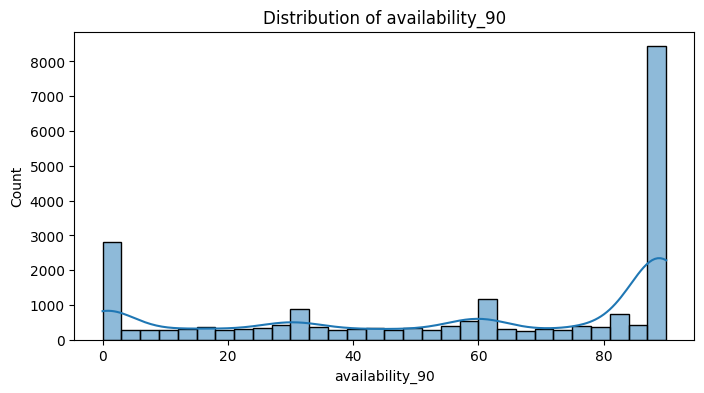

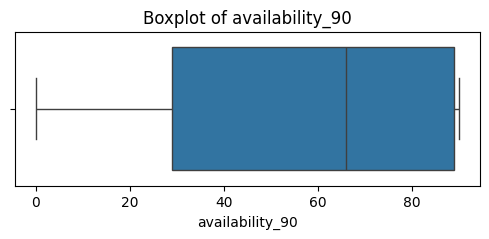

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 히스토그램 + 밀도곡선
plt.figure(figsize=(8, 4))
sns.histplot(df['availability_90'].dropna(), bins=30, kde=True)
plt.title('Distribution of availability_90')
plt.xlabel('availability_90')
plt.ylabel('Count')
plt.show()

# 2) 박스플롯 (이상치 확인용)
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['availability_90'].dropna())
plt.title('Boxplot of availability_90')
plt.xlabel('availability_90')
plt.show()


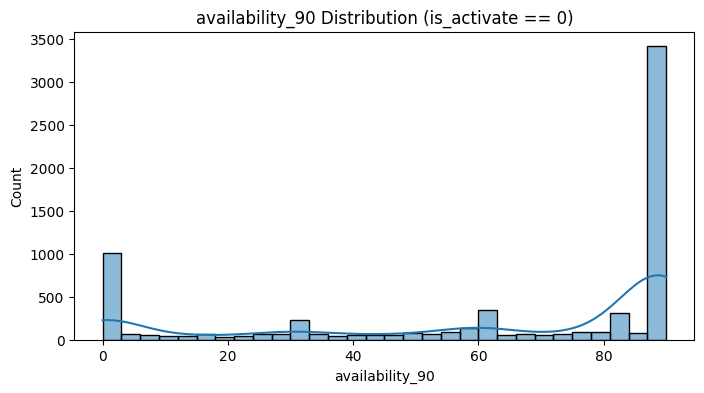

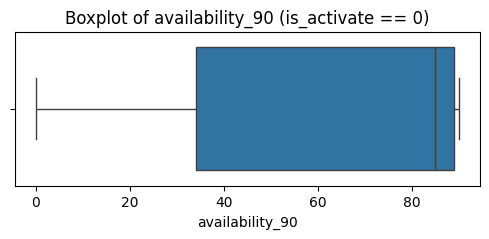

In [43]:
inactive = df[df['is_activate']==0]['availability_90']

import matplotlib.pyplot as plt
import seaborn as sns

# 1) 히스토그램 + 밀도곡선
plt.figure(figsize=(8,4))
sns.histplot(inactive.dropna(), bins=30, kde=True)
plt.title('availability_90 Distribution (is_activate == 0)')
plt.xlabel('availability_90')
plt.ylabel('Count')
plt.show()

# 2) 박스플롯
plt.figure(figsize=(6,2))
sns.boxplot(x=inactive.dropna())
plt.title('Boxplot of availability_90 (is_activate == 0)')
plt.xlabel('availability_90')
plt.show()

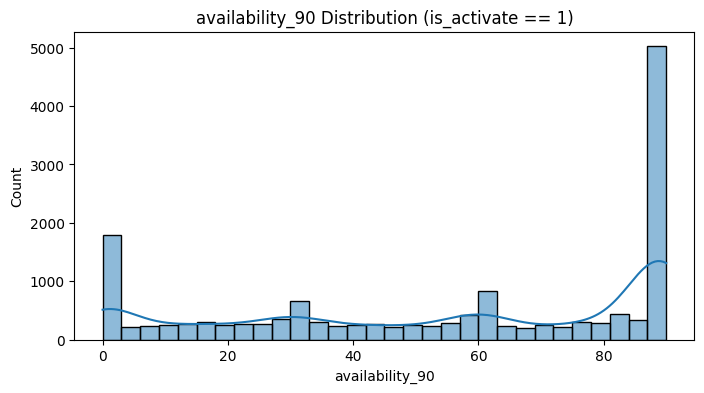

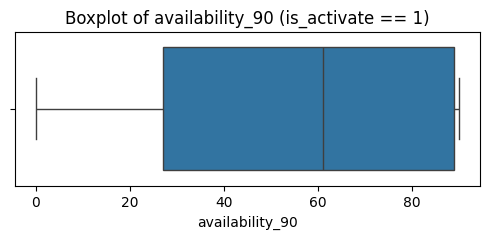

In [44]:
active = df[df['is_activate']==1]['availability_90']

# 1) 히스토그램 + 밀도곡선
plt.figure(figsize=(8,4))
sns.histplot(active.dropna(), bins=30, kde=True)
plt.title('availability_90 Distribution (is_activate == 1)')
plt.xlabel('availability_90')
plt.ylabel('Count')
plt.show()

# 2) 박스플롯
plt.figure(figsize=(6,2))
sns.boxplot(x=active.dropna())
plt.title('Boxplot of availability_90 (is_activate == 1)')
plt.xlabel('availability_90')
plt.show()

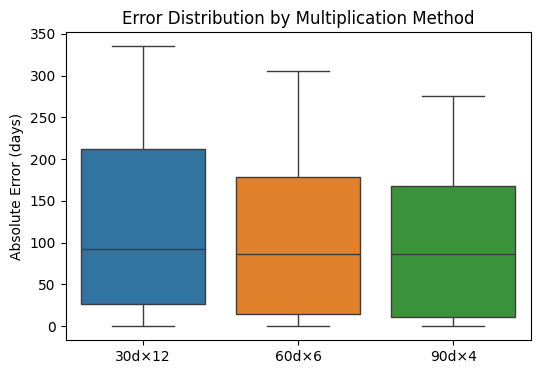

Friedman χ²=2223.585, p=0

Pairwise Wilcoxon (Bonferroni corrected):
 err_12m vs err_6b: W=31818417.0, raw_p=1.948e-272, corrected_p=5.843e-272
 err_12m vs err_4q: W=31075401.5, raw_p=0, corrected_p=0
 err_6b vs err_4q: W=35160937.5, raw_p=0, corrected_p=0


In [45]:
# “한 달×12, 60일×6, 90일×4” 중 뭐가 제일 좋을지


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare, wilcoxon

# 1) 진짜 연간 예약 일수 계산
df['reserved_true'] = 365 - df['availability_365']

# 2) 세 가지 추정 방식으로 연간 예약 일수 근사
df['reserved_12m'] = 365 - df['availability_30'] * 12
df['reserved_6b'] = 365 - df['availability_60'] * 6
df['reserved_4q'] = 365 - df['availability_90'] * 4

# 3) 음수·365 초과 방지(클리핑)
for col in ['reserved_12m','reserved_6b','reserved_4q']:
    df[col] = df[col].clip(0,365)

# 4) 절대 오차 계산
df['err_12m'] = (df['reserved_12m'] - df['reserved_true']).abs()
df['err_6b']  = (df['reserved_6b']  - df['reserved_true']).abs()
df['err_4q']  = (df['reserved_4q']  - df['reserved_true']).abs()

# 5) 오차 분포 시각화
plt.figure(figsize=(6,4))
sns.boxplot(data=df[['err_12m','err_6b','err_4q']])
plt.xticks([0,1,2], ['30d×12','60d×6','90d×4'])
plt.ylabel('Absolute Error (days)')
plt.title('Error Distribution by Multiplication Method')
plt.show()

# 6) Friedman 검정 (세 방법이 중앙값이 모두 동일한지)
stat, p = friedmanchisquare(df['err_12m'],
                            df['err_6b'],
                            df['err_4q'])
print(f"Friedman χ²={stat:.3f}, p={p:.4g}")

# 7) p<0.05 이면 사후검정: Wilcoxon signed‑rank test (쌍별)
from itertools import combinations
pairs = [('err_12m','err_6b'), ('err_12m','err_4q'), ('err_6b','err_4q')]
print("\nPairwise Wilcoxon (Bonferroni corrected):")
for a,b in pairs:
    stat_w, p_w = wilcoxon(df[a], df[b])
    p_corr = min(p_w * len(pairs), 1.0)
    print(f" {a} vs {b}: W={stat_w:.1f}, raw_p={p_w:.4g}, corrected_p={p_corr:.4g}")


In [46]:
import pandas as pd
import numpy as np


# 1) 90일 가용 → 연간 가용 근사
df['avail_365_est'] = df['availability_90'] * 4

# 2) 365에서 빼서 연간 예약 일수 근사
df['reserved_days_365'] = 365 - df['avail_365_est']


# 4) 논리적으로 0~365 사이 벗어나면 클리핑
df['reserved_days_365'] = df['reserved_days_365'].clip(lower=0, upper=365).round()

# 결과 확인
print(df[['availability_90','avail_365_est','is_activate','reserved_days_365']].head(10))


   availability_90  avail_365_est  is_activate  reserved_days_365
0               87            348            0                 17
1                0              0            1                365
2               66            264            1                101
3               25            100            1                265
4               38            152            1                213
5               90            360            0                  5
6               24             96            1                269
7               83            332            0                 33
8               61            244            1                121
9               25            100            1                265


In [47]:
import pandas as pd
import numpy as np
from scipy.stats import (
    shapiro, levene, ttest_ind, mannwhitneyu,
    f_oneway, kruskal, pearsonr, spearmanr
)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

ALPHA = 0.05
N_CAT = 10  # 최대 카테고리 수(이하일 때 범주형으로 처리)

def two_group_test(x, y):
    """2그룹 연속 vs 연속형 대상 검정 (t-test 계열 or Mann-Whitney)"""
    # 정규성 검사
    n1, n2 = shapiro(x).pvalue > ALPHA, shapiro(y).pvalue > ALPHA
    # 등분산성 검사
    ev = levene(x, y).pvalue > ALPHA
    
    if n1 and n2 and ev:
        return "Student’s t‑test", *ttest_ind(x, y, equal_var=True)
    elif n1 and n2 and not ev:
        return "Welch’s t‑test", *ttest_ind(x, y, equal_var=False)
    else:
        return "Mann–Whitney U", *mannwhitneyu(x, y, alternative='two-sided')

def multi_group_test(groups):
    """3개 이상 그룹 검정 (ANOVA or Kruskal–Wallis) + Tukey"""
    normals = [shapiro(g).pvalue > ALPHA for g in groups]
    ev = levene(*groups).pvalue > ALPHA
    if all(normals) and ev:
        stat, p = f_oneway(*groups)
        return "ANOVA", stat, p
    stat, p = kruskal(*groups)
    return "Kruskal–Wallis", stat, p

def corr_test(x, y):
    """연속 vs 연속 상관검정 (Pearson or Spearman)"""
    n1, n2 = shapiro(x).pvalue > ALPHA, shapiro(y).pvalue > ALPHA
    if n1 and n2:
        return "Pearson", *pearsonr(x, y)
    return "Spearman", *spearmanr(x, y)

def auto_feature_tests(df, target, n_cat=N_CAT):
    print(f"=== 자동 가설검정 (target={target}) ===")
    for feat in df.columns:
        if feat == target: 
            continue
        ser = df[feat].dropna()
        # 숫자 아닌 건 건너뜀
        if not pd.api.types.is_numeric_dtype(ser):
            continue
        
        nun = ser.nunique()
        print(f"\n▶ {feat} (n_unique={nun})")
        
        if nun == 2:
            # 두 그룹
            levels = sorted(ser.unique())
            x = df.loc[df[feat]==levels[0], target]
            y = df.loc[df[feat]==levels[1], target]
            name, stat, p = two_group_test(x, y)
            dec = "기각(차이있음)" if p<ALPHA else "채택(차이없음)"
            print(f"  {name}: stat={stat:.3f}, p={p:.4g} → {dec}")
        
        elif nun <= n_cat:
            # 다중 그룹
            groups = [g[target].values for _,g in df.groupby(feat)]
            name, stat, p = multi_group_test(groups)
            dec = "기각(차이있음)" if p<ALPHA else "채택(차이없음)"
            print(f"  {name}: stat={stat:.3f}, p={p:.4g} → {dec}")
            if name=="ANOVA" and p<ALPHA:
                print("   — 사후검정 (Tukey HSD):")
                print(pairwise_tukeyhsd(df[target], df[feat]))
        
        else:
            # 연속 vs 연속(상관)
            x = ser
            y = df[target].loc[ser.index]
            name, coef, p = corr_test(x, y)
            dec = "유의상관" if p<ALPHA else "상관무의미"
            print(f"  {name}: coef={coef:.3f}, p={p:.4g} → {dec}")


TARGET = "reserved_days_365"
auto_feature_tests(df, TARGET)

=== 자동 가설검정 (target=reserved_days_365) ===

▶ id (n_unique=22308)
  Spearman: coef=-0.024, p=0.0003522 → 유의상관

▶ host_id (n_unique=10934)
  Spearman: coef=-0.116, p=1.516e-67 → 유의상관

▶ host_since (n_unique=19)
  Spearman: coef=-0.122, p=7.475e-75 → 유의상관

▶ host_response_rate (n_unique=65)
  Spearman: coef=-0.020, p=0.003413 → 유의상관

▶ host_acceptance_rate (n_unique=96)
  Spearman: coef=0.105, p=5.012e-56 → 유의상관

▶ host_is_superhost (n_unique=2)
  Mann–Whitney U: stat=37350378.000, p=4.392e-181 → 기각(차이있음)

▶ host_listings_count (n_unique=109)
  Spearman: coef=0.118, p=1.293e-69 → 유의상관

▶ host_total_listings_count (n_unique=135)
  Spearman: coef=0.101, p=8.545e-52 → 유의상관

▶ host_has_profile_pic (n_unique=2)
  Mann–Whitney U: stat=5076817.000, p=7.608e-38 → 기각(차이있음)

▶ host_identity_verified (n_unique=2)
  Mann–Whitney U: stat=17311194.000, p=3.338e-13 → 기각(차이있음)

▶ latitude (n_unique=16512)
  Spearman: coef=0.043, p=1.274e-10 → 유의상관

▶ longitude (n_unique=15774)
  Spearman: coef=-0.173, p

/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22308.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16173.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6135.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accura

ValueError: Must enter at least two input sample vectors.

In [48]:
import pandas as pd
import numpy as np

from scipy.stats import (
    shapiro, levene,
    ttest_ind, mannwhitneyu,
    f_oneway, kruskal,
    pearsonr, spearmanr
)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

ALPHA = 0.05
N_CAT = 10  # 범주형으로 볼 최대 고유값 개수

def two_group_test(x, y):
    """2그룹 검정 → t‑test 계열 or Mann‑Whitney"""
    # ● 정규성
    n1 = shapiro(x).pvalue > ALPHA
    n2 = shapiro(y).pvalue > ALPHA
    # ● 등분산성
    ev = levene(x, y).pvalue > ALPHA
    
    if n1 and n2 and ev:
        return "Student’s t‑test", *ttest_ind(x, y, equal_var=True)
    elif n1 and n2 and not ev:
        return "Welch’s t‑test", *ttest_ind(x, y, equal_var=False)
    else:
        return "Mann–Whitney U", *mannwhitneyu(x, y, alternative="two-sided")

def multi_group_test(groups):
    """3개 이상 그룹 검정 → ANOVA or Kruskal‑Wallis"""
    normals = [shapiro(g).pvalue > ALPHA for g in groups]
    ev = levene(*groups).pvalue > ALPHA
    
    if all(normals) and ev:
        stat, p = f_oneway(*groups)
        return "ANOVA", stat, p
    stat, p = kruskal(*groups)
    return "Kruskal–Wallis", stat, p

def corr_test(x, y):
    """연속-연속 상관검정 → Pearson or Spearman"""
    n1 = shapiro(x).pvalue > ALPHA
    n2 = shapiro(y).pvalue > ALPHA
    if n1 and n2:
        return "Pearson", *pearsonr(x, y)
    return "Spearman", *spearmanr(x, y)

def auto_feature_tests(df, target, n_cat=N_CAT):
    print(f"=== 자동 가설검정 (target={target}) ===")
    
    for feat in df.columns:
        if feat == target:
            continue
        if not pd.api.types.is_numeric_dtype(df[feat]):
            # 숫자가 아니면 스킵
            continue
        
        # 1) feature 또는 target 결측치 제거
        tmp = df[[feat, target]].dropna()
        nun = tmp[feat].nunique()
        print(f"\n▶ {feat} (n_unique={nun})")
        
        # 2) 고유값이 1개 이하 → 검정 불가
        if nun < 2:
            print("  (샘플이 부족하여 검정 불가)")
            continue
        
        # --- 2범주이면 그룹검정 ---
        if nun == 2:
            levels = sorted(tmp[feat].unique())
            x = tmp.loc[tmp[feat] == levels[0], target]
            y = tmp.loc[tmp[feat] == levels[1], target]
            name, stat, p = two_group_test(x, y)
            decision = "기각(차이있음)" if p < ALPHA else "채택(차이없음)"
            print(f"  {name}: stat={stat:.3f}, p={p:.4g} → {decision}")
        
        # --- 3~n_cat 범주이면 다중그룹 검정 ---
        elif nun <= n_cat:
            groups = [g[target].values 
                      for _, g in tmp.groupby(feat)]
            name, stat, p = multi_group_test(groups)
            decision = "기각(차이있음)" if p < ALPHA else "채택(차이없음)"
            print(f"  {name}: stat={stat:.3f}, p={p:.4g} → {decision}")
            
            # ANOVA + 유의미 → Tukey HSD 사후검정
            if name == "ANOVA" and p < ALPHA:
                print("   — 사후검정 (Tukey HSD) —")
                print(pairwise_tukeyhsd(tmp[target], tmp[feat]))
        
        # --- 그 외 (연속 vs 연속) → 상관검정 ---
        else:
            x = tmp[feat]
            y = tmp[target]
            name, coef, p = corr_test(x, y)
            decision = "유의상관" if p < ALPHA else "상관무의미"
            print(f"  {name}: coef={coef:.3f}, p={p:.4g} → {decision}")

# 사용 예시
TARGET = "reserved_days_365"
auto_feature_tests(df, TARGET)


=== 자동 가설검정 (target=reserved_days_365) ===

▶ id (n_unique=22308)
  Spearman: coef=-0.024, p=0.0003522 → 유의상관

▶ host_id (n_unique=10934)
  Spearman: coef=-0.116, p=1.516e-67 → 유의상관

▶ host_since (n_unique=19)
  Spearman: coef=-0.122, p=7.475e-75 → 유의상관

▶ host_response_rate (n_unique=65)
  Spearman: coef=-0.020, p=0.003413 → 유의상관

▶ host_acceptance_rate (n_unique=96)
  Spearman: coef=0.105, p=5.012e-56 → 유의상관

▶ host_is_superhost (n_unique=2)
  Mann–Whitney U: stat=37350378.000, p=4.392e-181 → 기각(차이있음)

▶ host_listings_count (n_unique=109)
  Spearman: coef=0.118, p=1.293e-69 → 유의상관

▶ host_total_listings_count (n_unique=135)
  Spearman: coef=0.101, p=8.545e-52 → 유의상관

▶ host_has_profile_pic (n_unique=2)
  Mann–Whitney U: stat=5076817.000, p=7.608e-38 → 기각(차이있음)

▶ host_identity_verified (n_unique=2)
  Mann–Whitney U: stat=17311194.000, p=3.338e-13 → 기각(차이있음)

▶ latitude (n_unique=16512)
  Spearman: coef=0.043, p=1.274e-10 → 유의상관

▶ longitude (n_unique=15774)
  Spearman: coef=-0.173, p

/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22308.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22308.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22308.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accur

  Kruskal–Wallis: stat=51.467, p=6.669e-12 → 기각(차이있음)

▶ host_about_length (n_unique=880)
  Spearman: coef=0.138, p=1.424e-95 → 유의상관

▶ host_about_length_group (n_unique=3)
  Kruskal–Wallis: stat=282.788, p=3.92e-62 → 기각(차이있음)

▶ host_response_time_score (n_unique=4)
  Kruskal–Wallis: stat=185.534, p=5.626e-40 → 기각(차이있음)

▶ host_response_rate_score (n_unique=4)
  Kruskal–Wallis: stat=124.353, p=8.909e-27 → 기각(차이있음)

▶ host_acceptance_rate_score (n_unique=4)
  Kruskal–Wallis: stat=201.706, p=1.805e-43 → 기각(차이있음)

▶ host_location_boolean (n_unique=2)
  Mann–Whitney U: stat=40062527.000, p=1.567e-33 → 기각(차이있음)

▶ host_location_ny (n_unique=2)
  Mann–Whitney U: stat=47111488.500, p=5.21e-56 → 기각(차이있음)

▶ is_shared (n_unique=2)
  Mann–Whitney U: stat=50875073.500, p=3.459e-31 → 기각(차이있음)

▶ is_private (n_unique=2)
  Mann–Whitney U: stat=41308313.500, p=3.459e-31 → 기각(차이있음)

▶ bath_score_mul (n_unique=21)
  Spearman: coef=0.066, p=7.454e-23 → 유의상관

▶ is_activate (n_unique=2)
  Mann–Whitney U:

/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16038.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20572.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16310.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accur

In [49]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1) 데이터 불러오기 & 피처/타깃 설정
TARGET = "reserved_days_365"
features = [  # 앞서 선정한 피처 리스트
 'price',
 'estimated_occupancy_l365d',
 'instant_bookable',
 'host_listings_count',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'structure_encoded',
 'last_review']
X = df[features].fillna(0)
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 하이퍼파라미터 분포 설정
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("✔ Best RF params:", rf_search.best_params_)
print("✔ Best XGB params:", xgb_search.best_params_)

# 5) 검증 성능 (튜닝 후)
def eval_model(model, X_t, y_t):
    y_pred = model.predict(X_t)
    return root_mean_squared_error(y_t, y_pred), mean_absolute_error(y_t, y_pred), r2_score(y_t, y_pred)

rf_rmse, rf_mae, rf_r2 = eval_model(best_rf, X_test, y_test)
xgb_rmse, xgb_mae, xgb_r2 = eval_model(best_xgb, X_test, y_test)
print(f"RF tuned  RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}, R2 Score={rf_r2:.2f}")
print(f"XGB tuned RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, R2 Score={xgb_r2:.2f}")

# 6) Ensemble: Voting Regressor
voting = VotingRegressor([("rf", best_rf), ("xgb", best_xgb)])
voting.fit(X_train, y_train)
v_rmse, v_mae, v_r2 = eval_model(voting, X_test, y_test)
print(f"Voting   RMSE={v_rmse:.2f}, MAE={v_mae:.2f}, R2 Score={v_r2:.2f}")

# 7) Ensemble: Stacking Regressor
stack = StackingRegressor(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train, y_train)
s_rmse, s_mae, s_r2 = eval_model(stack, X_test, y_test)
print(f"Stacking RMSE={s_rmse:.2f}, MAE={s_mae:.2f}, R2 Score={s_r2:.2f}")


KeyboardInterrupt: 

In [ ]:
df['reserved_rate_365'] = df['reserved_days_365'] / 365


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1) 데이터 불러오기 & 피처/타깃 설정
TARGET = "reserved_rate_365"
features = [  # 앞서 선정한 피처 리스트
 'price',
 'estimated_occupancy_l365d',
 'instant_bookable',
 'host_listings_count',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'structure_encoded',
 'last_review']
X = df[features].fillna(0)
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 하이퍼파라미터 분포 설정
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("✔ Best RF params:", rf_search.best_params_)
print("✔ Best XGB params:", xgb_search.best_params_)

# 5) 검증 성능 (튜닝 후)
def eval_model(model, X_t, y_t):
    y_pred = model.predict(X_t)
    return root_mean_squared_error(y_t, y_pred), mean_absolute_error(y_t, y_pred), r2_score(y_t, y_pred)

rf_rmse, rf_mae, rf_r2 = eval_model(best_rf, X_test, y_test)
xgb_rmse, xgb_mae, xgb_r2 = eval_model(best_xgb, X_test, y_test)
print(f"RF tuned  RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}, R2 Score={rf_r2:.2f}")
print(f"XGB tuned RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, R2 Score={xgb_r2:.2f}")

# 6) Ensemble: Voting Regressor
voting = VotingRegressor([("rf", best_rf), ("xgb", best_xgb)])
voting.fit(X_train, y_train)
v_rmse, v_mae, v_r2 = eval_model(voting, X_test, y_test)
print(f"Voting   RMSE={v_rmse:.2f}, MAE={v_mae:.2f}, R2 Score={v_r2:.2f}")

# 7) Ensemble: Stacking Regressor
stack = StackingRegressor(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train, y_train)
s_rmse, s_mae, s_r2 = eval_model(stack, X_test, y_test)
print(f"Stacking RMSE={s_rmse:.2f}, MAE={s_mae:.2f}, R2 Score={s_r2:.2f}")


✔ Best RF params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
✔ Best XGB params: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
RF tuned  RMSE=0.31, MAE=0.25, R2 Score=0.29
XGB tuned RMSE=0.31, MAE=0.24, R2 Score=0.31
Voting   RMSE=0.31, MAE=0.25, R2 Score=0.32
Stacking RMSE=0.31, MAE=0.24, R2 Score=0.32


In [ ]:
df['r_log'] = np.log1p(df['reserved_days_365'])
df['price_log'] = np.log1p(df['price'])

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1) 데이터 불러오기 & 피처/타깃 설정
TARGET = "reserved_days_365"
features = [  # 앞서 선정한 피처 리스트
 'price_log',
 'estimated_occupancy_l365d',
 'instant_bookable',
 'host_listings_count',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'structure_encoded',
 'last_review']
X = df[features].fillna(0)
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 하이퍼파라미터 분포 설정
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("✔ Best RF params:", rf_search.best_params_)
print("✔ Best XGB params:", xgb_search.best_params_)

# 5) 검증 성능 (튜닝 후)
def eval_model(model, X_t, y_t):
    y_pred = model.predict(X_t)
    return root_mean_squared_error(y_t, y_pred), mean_absolute_error(y_t, y_pred), r2_score(y_t, y_pred)

rf_rmse, rf_mae, rf_r2 = eval_model(best_rf, X_test, y_test)
xgb_rmse, xgb_mae, xgb_r2 = eval_model(best_xgb, X_test, y_test)
print(f"RF tuned  RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}, R2 Score={rf_r2:.2f}")
print(f"XGB tuned RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, R2 Score={xgb_r2:.2f}")

# 6) Ensemble: Voting Regressor
voting = VotingRegressor([("rf", best_rf), ("xgb", best_xgb)])
voting.fit(X_train, y_train)
v_rmse, v_mae, v_r2 = eval_model(voting, X_test, y_test)
print(f"Voting   RMSE={v_rmse:.2f}, MAE={v_mae:.2f}, R2 Score={v_r2:.2f}")

# 7) Ensemble: Stacking Regressor
stack = StackingRegressor(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train, y_train)
s_rmse, s_mae, s_r2 = eval_model(stack, X_test, y_test)
print(f"Stacking RMSE={s_rmse:.2f}, MAE={s_mae:.2f}, R2 Score={s_r2:.2f}")


✔ Best RF params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
✔ Best XGB params: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
RF tuned  RMSE=113.79, MAE=91.07, R2 Score=0.29
XGB tuned RMSE=112.22, MAE=89.20, R2 Score=0.31
Voting   RMSE=111.74, MAE=89.46, R2 Score=0.32
Stacking RMSE=111.67, MAE=89.32, R2 Score=0.32


In [ ]:
pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 이상치 제거

In [57]:
csv_path = '/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/1.preprocessing/entire_remove_outlier.csv'    # 여기에 absolute path
# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)
df.index.name = 'id'
# 데이터 확인
df

,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,structure_encoded,log_price,room_new_type
id,,,,,,,,,,,,,,,,,,,,,
0,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,NaN,...,False,False,False,False,False,True,False,23,5.303305,mid
1,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,NaN,...,True,False,False,False,False,True,False,8,4.418841,upper-mid
2,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010,"New York, NY",I have been a New Yorker for a long time\n and...,within an hour,...,True,False,False,True,False,False,False,14,4.941642,low-mid
3,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010,"New York, NY",I am a music producer. And my wife is a hair s...,within an hour,...,False,False,False,False,False,True,False,23,4.875197,mid
4,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,169927,Hubert,2010,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",NaN,...,True,False,False,False,False,True,False,23,4.941642,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015,"New York, NY",NaN,NaN,...,True,False,False,False,False,True,False,23,4.290459,mid
20556,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022,"New York, NY",Are you tired of the tedious and time-consumin...,within an hour,...,False,False,False,False,False,True,False,23,4.077537,mid
20557,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015,"Hawthorne, NJ",NaN,within an hour,...,True,False,False,True,False,False,False,23,5.703782,mid


In [64]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1) 데이터 불러오기 & 피처/타깃 설정
TARGET = "estimated_occupancy_l365d"
features = [  # 앞서 선정한 피처 리스트
 'log_price',
 'instant_bookable',
 'availability_90',
 'host_listings_count',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'number_of_reviews',
 'review_scores_rating',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'structure_encoded',
 'last_review',]
X = df[features].fillna(0)
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 하이퍼파라미터 분포 설정
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("✔ Best RF params:", rf_search.best_params_)
print("✔ Best XGB params:", xgb_search.best_params_)

# 5) 검증 성능 (튜닝 후)
def eval_model(model, X_t, y_t):
    y_pred = model.predict(X_t)
    return root_mean_squared_error(y_t, y_pred), mean_absolute_error(y_t, y_pred), r2_score(y_t, y_pred)

rf_rmse, rf_mae, rf_r2 = eval_model(best_rf, X_test, y_test)
xgb_rmse, xgb_mae, xgb_r2 = eval_model(best_xgb, X_test, y_test)
print(f"RF tuned  RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}, R2 Score={rf_r2:.2f}")
print(f"XGB tuned RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, R2 Score={xgb_r2:.2f}")

# 6) Ensemble: Voting Regressor
voting = VotingRegressor([("rf", best_rf), ("xgb", best_xgb)])
voting.fit(X_train, y_train)
v_rmse, v_mae, v_r2 = eval_model(voting, X_test, y_test)
print(f"Voting   RMSE={v_rmse:.2f}, MAE={v_mae:.2f}, R2 Score={v_r2:.2f}")

# 7) Ensemble: Stacking Regressor
stack = StackingRegressor(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train, y_train)
s_rmse, s_mae, s_r2 = eval_model(stack, X_test, y_test)
print(f"Stacking RMSE={s_rmse:.2f}, MAE={s_mae:.2f}, R2 Score={s_r2:.2f}")

print(rf_r2, xgb_r2, v_r2, s_r2)


✔ Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
✔ Best XGB params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
RF tuned  RMSE=35.57, MAE=17.66, R2 Score=0.87
XGB tuned RMSE=35.53, MAE=18.61, R2 Score=0.87
Voting   RMSE=35.22, MAE=18.00, R2 Score=0.87
Stacking RMSE=35.21, MAE=18.06, R2 Score=0.87
0.8667752800611671 0.8670598268508911 0.8694049215559325 0.8694547336024965


In [65]:
from sklearn.model_selection import cross_validate, KFold
import numpy as np

# 1) 평가 지표와 폴드 설정
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae':  'neg_mean_absolute_error',
    'r2':   'r2'
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2) 교차검증 수행 (stack 가 이미 최종 모델이라면 stack, 아니면 best_rf / best_xgb 등)
cv_results = cross_validate(
    stack, X, y,
    cv=kf, scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# 3) 결과 집계
print("RMSE:",  -np.mean(cv_results['test_rmse']),  "±", np.std(cv_results['test_rmse']))
print("MAE: ",  -np.mean(cv_results['test_mae']),   "±", np.std(cv_results['test_mae']))
print("R2:  ",   np.mean(cv_results['test_r2']),    "±", np.std(cv_results['test_r2']))


RMSE: 36.9433805724676 ± 1.1659941850040205
MAE:  18.909944662280125 ± 0.6907269721866532
R2:   0.8557632757112543 ± 0.010292682906490965


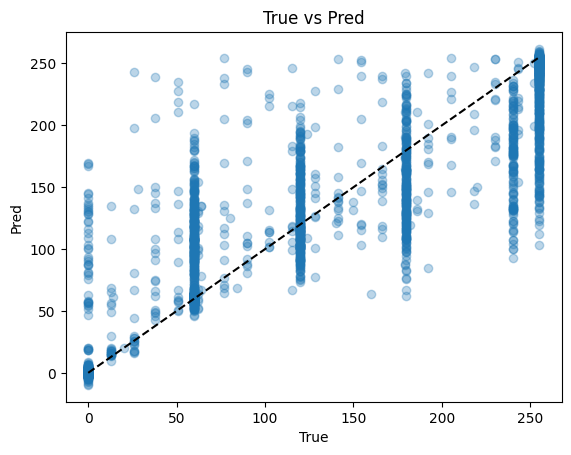

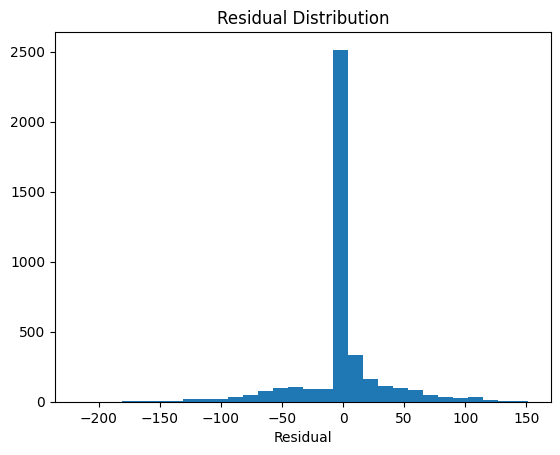

In [67]:
import matplotlib.pyplot as plt

# 1) 테스트셋 예측
y_pred = stack.predict(X_test)

# 2) scatter: 실제 vs 예측
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')  # 완벽 예측 대각선
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("True vs Pred")
plt.show()

# 3) 잔차 히스토그램
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.title("Residual Distribution")
plt.show()


In [68]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy_scores = cross_validate(dummy, X, y, cv=kf, scoring=scoring, n_jobs=-1)
print("Dummy RMSE:", -np.mean(dummy_scores['test_rmse']))
print("Dummy R2:  ",  np.mean(dummy_scores['test_r2']))


Dummy RMSE: 97.36885532751725
Dummy R2:   -0.00033285894862919994


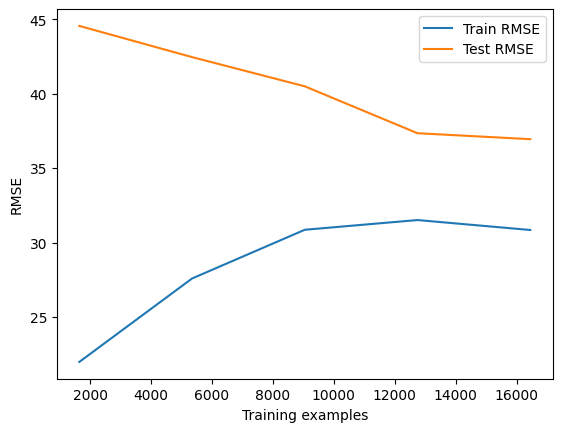

In [66]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    stack, X, y, cv=kf, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_rmse = -np.mean(train_scores, axis=1)
test_rmse  = -np.mean(test_scores,  axis=1)

plt.figure()
plt.plot(train_sizes, train_rmse, label="Train RMSE")
plt.plot(train_sizes, test_rmse,  label="Test RMSE")
plt.xlabel("Training examples")
plt.ylabel("RMSE")
plt.legend()
plt.show()


In [70]:
import numpy as np

# 1) 50% 분위(=중앙값) 직접 계산
median = y_train.quantile(0.50)

# 2) –inf ~ median / median ~ +inf
bins   = [-np.inf, median, np.inf]
labels = ['low50','high50']

segments = pd.cut(y_train, bins=bins, labels=labels)
segments.value_counts()


estimated_occupancy_l365d
low50     8761
high50    7687
Name: count, dtype: int64

In [73]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestRegressor
from sklearn.metrics      import root_mean_squared_error, mean_absolute_error, r2_score

# --- 0) df, features, TARGET 정의된 상태라 가정 ---
# 예시:
# TARGET   = "estimated_occupancy_l365d"
# features = [... your feature list ...]

# 1) train/test split
X = df[features].fillna(0)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) 하위70% vs 상위30% 구간 라벨링
threshold = y_train.quantile(0.70)  # 70% 분위값
bins      = [-np.inf, threshold, np.inf]
labels    = ['low70', 'high30']

seg_train = pd.cut(y_train, bins=bins, labels=labels)
seg_test  = pd.cut(y_test,  bins=bins, labels=labels)

# 3) 구간 분류기 학습 (DecisionTree)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, seg_train)

# 4) 각 구간별 회귀모델 학습 (RandomForest)
models = {}
for seg in labels:
    mask = (seg_train == seg)
    m = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=3,
        random_state=42
    )
    m.fit(X_train[mask], y_train[mask])
    models[seg] = m

# 5) 테스트 데이터 “분류 → 해당 회귀” 예측
seg_pred = clf.predict(X_test)
y_pred   = np.empty(len(y_test), dtype=float)

for seg in labels:
    mask = (seg_pred == seg)
    y_pred[mask] = models[seg].predict(X_test[mask])

# 6) 전체 성능 평가
rmse = root_mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"Overall   RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.3f}")

# 7) 구간별 성능 확인
for seg in labels:
    mask = (seg_test == seg)
    rmse_s = root_mean_squared_error(y_test[mask], y_pred[mask])
    r2_s   = r2_score(y_test[mask], y_pred[mask])
    print(f"{seg:>6}  RMSE={rmse_s:.2f}, R2={r2_s:.3f}")


Overall   RMSE=48.51, MAE=21.80, R2=0.752
 low70  RMSE=39.98, R2=0.005
high30  RMSE=67.51, R2=-2.433
